# Performance as well as Validation benchmarks for activation function implementations in the different frameworks

# CPU versions only

Windows 11
i7 11800H
Nvidia 3050 Ti

I used 

`conda install 'tensorflow=*=mkl*'`
and 

`conda install pytorch torchvision torchaudio cpuonly -c pytorch`

`pip install crysx_nn`

## Run the following for Google colab 
then restart runtime

In [1]:

# ! pip install crysx_nn
# ! pip install IPython==7.7.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Ensure that evertyhing is only using CPU¶

import numpy as np
np.show_config()
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import ReLU, ReLU_grad

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [6]:
X_torch = torch.rand((300,100),requires_grad=True)
print(X_torch)

tensor([[0.9295, 0.2186, 0.1167,  ..., 0.1477, 0.6173, 0.3591],
        [0.4443, 0.1311, 0.7939,  ..., 0.3509, 0.8844, 0.3112],
        [0.6778, 0.1382, 0.2076,  ..., 0.5439, 0.1027, 0.2268],
        ...,
        [0.8449, 0.0499, 0.8145,  ..., 0.9016, 0.8372, 0.5602],
        [0.0429, 0.8661, 0.4183,  ..., 0.1306, 0.9409, 0.7862],
        [0.9635, 0.0949, 0.5816,  ..., 0.3559, 0.8114, 0.7775]],
       requires_grad=True)


## Convert it to numpy for `crysx_nn`

In [7]:
X_crysx_nn = X_torch.cpu().detach().numpy()
print(X_crysx_nn.dtype)

float32


## Now finally convert it to a tensorflow tensor

In [8]:
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

## Benchmark ReLU

### Confirm that all frameworks give the same results

In [9]:
# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)

# CrysX
relu_crysx_nn_value = ReLU(X_crysx_nn)

# Tensorflow
relu_tf_value = tf.nn.relu(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(relu_torch_value.cpu().detach().numpy() - relu_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(relu_torch_value.cpu().detach().numpy() - relu_crysx_nn_value).max())

Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

In [10]:
# Torch
print('PyTorch')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 relu_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 ReLU(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.relu(X_tf)


PyTorch
20.1 µs ± 958 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
4.25 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
7.11 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [11]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o relu_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o ReLU(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    with tf.device("cpu:0"):
        time = %timeit -n 500 -o tf.nn.relu(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

5.09 µs ± 419 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
783 ns ± 30.5 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.55 µs ± 282 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
24.8 µs ± 670 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
42.4 µs ± 2.62 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
38 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
619 µs ± 51.2 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
958 µs ± 200 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
705 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.14 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.05 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.16 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.01 ms ± 39.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.23 ms ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.8

### Plot the results

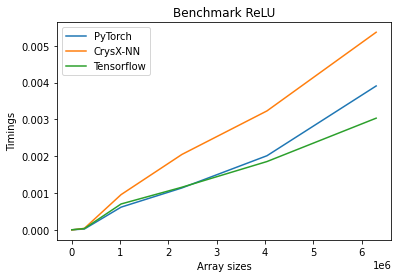

In [12]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark ReLU')
plt.show()

## Benchmark ReLU derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [13]:
def tf_relu_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        relu_values = tf.nn.relu(x)
    grad = g.gradient(relu_values, x)
    return grad#.numpy()

In [14]:
def torch_relu_grad(relu_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=relu_values, inputs=x,
                          grad_outputs=torch.ones(relu_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [15]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
gradientsTorch = torch_relu_grad(relu_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = ReLU_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_relu_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
gradientsTF = g.gradient(relu_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [16]:
# Torch
print('PyTorch gradient only')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
%timeit -n 100 torch_relu_grad(relu_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 ReLU_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_relu_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.relu(X_tf)


PyTorch gradient only
1.25 ms ± 40 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
1.07 ms ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
2.44 ms ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
787 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Sigmoid

### Confirm that all frameworks give the same results

In [17]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)

# CrysX
sigmoid_crysx_nn_value = Sigmoid(X_crysx_nn)


# Tensorflow
sigmoid_tf_value = tf.keras.activations.sigmoid(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_crysx_nn_value).max())


Max abs diff b/w torch and tf 1.1920929e-07
Max abs diff b/w torch and CrysX 5.9604645e-08


### Compare performance

In [11]:
# Torch
print('PyTorch')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
%timeit -n 100 sigmoid_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Sigmoid(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)


PyTorch
1.51 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
1.49 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
951 µs ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [12]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = 1000*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o sigmoid_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Sigmoid(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.sigmoid(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

10.4 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.9 µs ± 2.65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.2 µs ± 883 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.63 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.06 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
58 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.61 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.57 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
793 µs ± 75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.6 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.35 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.4 ms ± 528 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.5 ms ± 937 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.33 

### Plot the results

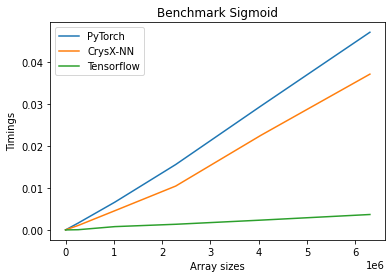

In [13]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Sigmoid')
plt.show()


## Benchmark Sigmoid derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [22]:
def tf_sigmoid_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        sigmoid_values = tf.nn.sigmoid(x)
    grad = g.gradient(sigmoid_values, x)
    return grad#.numpy()

In [23]:
def torch_sigmoid_grad(sigmoid_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=sigmoid_values, inputs=x,
                          grad_outputs=torch.ones(sigmoid_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [24]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
gradientsTorch = torch_sigmoid_grad(sigmoid_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Sigmoid_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_sigmoid_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
gradientsTF = g.gradient(sigmoid_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 1.4156103e-07
Max abs diff b/w torch and CrysX 8.381903e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [25]:
# Torch
print('PyTorch gradient only')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
%timeit -n 100 torch_sigmoid_grad(sigmoid_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Sigmoid_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
# %timeit -n 100 g.gradient(sigmoid_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_sigmoid_grad(X_tf)
print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)



PyTorch gradient only
1.48 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
1.47 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
3.12 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
961 µs ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast for a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Softmax

### Confirm that all frameworks give the same results

In [26]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)

# CrysX
softmax_crysx_nn_value = Softmax(X_crysx_nn)

# Tensorflow
softmax_tf_value = tf.keras.activations.softmax(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(softmax_torch_value.cpu().detach().numpy() - softmax_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(softmax_torch_value.cpu().detach().numpy() - softmax_crysx_nn_value).max())


Max abs diff b/w torch and tf 5.9604645e-08
Max abs diff b/w torch and CrysX 5.9604645e-08


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


### Compare performance

In [27]:
# Torch
print('PyTorch')
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
%timeit -n 100 softmax_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Softmax(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.softmax(X_tf)


PyTorch


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


2.13 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
3.89 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
1.16 ms ± 85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [28]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,2500,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    softmax_torch_func = torch.nn.Softmax() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o softmax_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Softmax(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.softmax(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

12.3 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.96 µs ± 97 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.35 µs ± 636 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


441 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
527 µs ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
224 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.99 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.38 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.14 ms ± 98.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.3 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.7 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.06 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.79 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.5 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.64 ms ± 600 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Plot the results

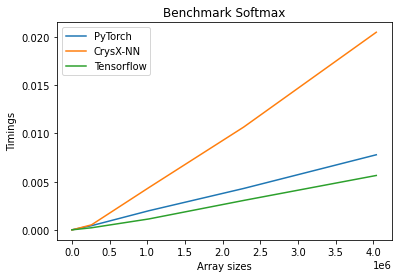

In [29]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Softmax')
plt.show()


## Benchmark Softmax derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function.

Therefore, it is not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

#### Update: Seems to be really problematic to get the jacobian of Softmax wrt inputs in an efficient manner using the PyTorch framework. 

There are ways in which you can do it, but they would be slow. (https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16)

So take the timing results with a grain of salt.

In [30]:
def tf_softmax_grad(z):
#   z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = tf.nn.softmax(z) 
    jacob = g.batch_jacobian(a, z)
    return jacob#.numpy()

In [31]:
# Reference: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16
def torch_softmax_grad(wrt):
    jacobian = []
    softmax_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
    softmax_func.eval()
    for i in range(wrt.shape[0]):
        jac = torch.autograd.functional.jacobian(softmax_func, wrt[i])
        jacobian.append(jac)
        #
    return torch.stack(jacobian, 0)

### Confirm that all frameworks give the same results

In [32]:
# Torch input
X_torch = torch.rand((100,100),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
# softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)
device = 'cpu'
gradientsTorch = torch_softmax_grad(X_torch)#torch.autograd.grad(outputs=softmax_torch_value, inputs=X_torch,
#                           grad_outputs=torch.ones(softmax_torch_value.size()).to(device),
#                           create_graph=True, retain_graph=True, only_inputs=True)[0]
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Softmax_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
# softmax_tf_value = tf.nn.softmax(X_tf)
gradientsTF = tf_softmax_grad(X_tf)
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\torch\autograd\functional.py:482: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = func(*inputs)


Max abs diff b/w torch and tf 2.9802322e-08
Max abs diff b/w torch and CrysX 3.7252903e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [33]:
# Torch
print('PyTorch')
%timeit -n 10 torch_softmax_grad(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 10 Softmax_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 10 tf_softmax_grad(X_tf)


PyTorch
316 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
CrysX-NN (crysx_nn)
3.48 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Tensorflow
221 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
